In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [2]:
## SPATIAL DATA

# Audio bias of HC
HC_bias_a = np.zeros((3, 8))
# HC_bias_a[0]--High; HC_bias_a[1]--Medium; HC_bias_a[2]--Low
HC_bias_a[0] = np.array(
    [
        -5.21640112246667,
        -4.18706601266667,
        -3.13696911613333,
        -2.09924748133333,
        1.35796414540000,
        3.07563797893333,
        3.81842299133333,
        3.35914483333333,
    ]
)
HC_bias_a[1] = np.array(
    [
        -4.65343309471429,
        -5.46053503785714,
        -2.09086371792857,
        -1.13832656671429,
        -0.277120626642857,
        0.262638716714286,
        2.19984634542857,
        3.40839929092857,
    ]
)
HC_bias_a[2] = np.array(
    [
        -2.93714767620000,
        -2.81604437300000,
        -1.61590862560000,
        -1.98143368426667,
        -1.29873315480000,
        0.0165255805333333,
        0.501353158466667,
        1.16135676946667,
    ]
)

# Causal Inference of HC
HC_pro_com = np.array(
    [
        [
            0.367025484375000,
            0.682562911541667,
            0.822405755208334,
            0.876760716875000,
            0.863113007208333,
            0.809197201583333,
            0.649743997500000,
            0.321256356083333,
        ],
        [
            0.435277895916667,
            0.621660267583333,
            0.659722209500000,
            0.704617010791667,
            0.724928494125000,
            0.687408309375000,
            0.612227719333333,
            0.446587043833333,
        ],
        [
            0.519254406291667,
            0.624221809791667,
            0.623241935666667,
            0.633213512666667,
            0.650625944875000,
            0.645931453375000,
            0.608952192000000,
            0.537992153875000,
        ],
    ]
)

In [3]:
## TEMPORAL DATA

temporal_dis = (
    np.array(
        [
            -0.7,
            -0.5,
            -0.3,
            -0.25,
            -0.2,
            -0.15,
            -0.1,
            -0.08,
            -0.05,
            -0.02,
            -0.01,
            0.0,
            0.01,
            0.02,
            0.05,
            0.08,
            0.1,
            0.15,
            0.2,
            0.25,
            0.3,
            0.5,
            0.7,
        ]
    )
    * 1000
)

temporal_causes_data = np.array(
    [
        0.03154762,
        0.03214286,
        0.07619048,
        0.19699793,
        0.30345238,
        0.50193093,
        0.72754579,
        0.82582418,
        0.90882784,
        0.93468864,
        0.97271062,
        0.97710623,
        0.95398352,
        0.94500916,
        0.94871795,
        0.94787546,
        0.92052078,
        0.87787546,
        0.75857143,
        0.51714286,
        0.33121212,
        0.05779221,
        0.02836439,
    ]
)

In [4]:
from scipy.optimize import differential_evolution
from skneuromsi.sweep import ParameterSweep

dis = np.array([-24, -12, -6, -3, 3, 6, 12, 24])  # disparities
bias_data = np.abs(HC_bias_a[0]) / np.abs(dis)
causes_data = HC_pro_com[0]

## Alais and Burr


In [5]:
from skneuromsi.mle import AlaisBurr2004


def alais_job(a_sigma, v_sigma):
    model = AlaisBurr2004(position_range=(0, 90), position_res=1)
    sp = ParameterSweep(
        model=model, target="visual_position", repeat=1, n_jobs=1, range=45 + dis
    )
    res = sp.run(
        auditory_position=45, visual_sigma=v_sigma, auditory_sigma=a_sigma, noise=False
    )
    bias = res.bias.bias_mean(
        influence_parameter="auditory_position", mode="multi", quiet=True
    )
    return bias.values[:, 0]


def alais_cost(theta):
    model_data = alais_job(theta[0], theta[1])
    exp_data = bias_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48)]
alais_fit_res = differential_evolution(
    alais_cost, bounds, disp=True, updating="deferred", workers=-1, polish=False
)
print(alais_fit_res)

differential_evolution step 1: f(x)= 9.05023
differential_evolution step 2: f(x)= 9.05023
differential_evolution step 3: f(x)= 9.05023
differential_evolution step 4: f(x)= 9.05023
differential_evolution step 5: f(x)= 9.05023
differential_evolution step 6: f(x)= 9.05023
differential_evolution step 7: f(x)= 9.05023
differential_evolution step 8: f(x)= 9.05023
differential_evolution step 9: f(x)= 9.05023
differential_evolution step 10: f(x)= 9.05023
differential_evolution step 11: f(x)= 9.05023
differential_evolution step 12: f(x)= 9.05023
differential_evolution step 13: f(x)= 9.05023
differential_evolution step 14: f(x)= 9.05023
differential_evolution step 15: f(x)= 9.05023
differential_evolution step 16: f(x)= 9.05023
 message: Optimization terminated successfully.
 success: True
     fun: 9.050229183250034
       x: [ 3.397e+01  3.394e+01]
     nit: 16
    nfev: 510


Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

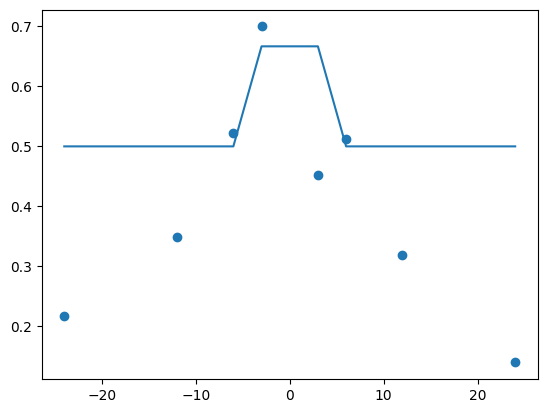

In [6]:
alais_model_fit = alais_job(alais_fit_res.x[0], alais_fit_res.x[1])

plt.plot(dis, alais_model_fit)
plt.scatter(dis, bias_data)

## Kording

In [8]:
from skneuromsi.bayesian import Kording2007


def kording_job(a_sigma, v_sigma, p_mu, p_sigma):
    model = Kording2007(position_range=(0, 90), position_res=1)
    sp = ParameterSweep(
        model=model, target="visual_position", repeat=1, n_jobs=1, range=45 + dis
    )
    res = sp.run(
        auditory_position=45,
        visual_sigma=v_sigma,
        auditory_sigma=a_sigma,
        noise=False,
        prior_mu=p_mu,
        prior_sigma=p_sigma,
        strategy="averaging",
    )
    bias = res.bias.bias_mean(
        influence_parameter="auditory_position", mode="auditory", quiet=True
    )
    return bias.values[:, 0]


def kording_cost(theta):
    model_data = kording_job(theta[0], theta[1], theta[2], theta[3])
    exp_data = bias_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48), (21, 69), (0.1, 48)]
kording_fit_res = differential_evolution(
    kording_cost, bounds, disp=True, updating="deferred", workers=-1, polish=False
)
print(kording_fit_res)

differential_evolution step 1: f(x)= 1.77488
differential_evolution step 2: f(x)= 1.77488
differential_evolution step 3: f(x)= 1.77488
differential_evolution step 4: f(x)= 1.77488
differential_evolution step 5: f(x)= 1.46037
differential_evolution step 6: f(x)= 1.32331
differential_evolution step 7: f(x)= 1.00139
differential_evolution step 8: f(x)= 1.00139
differential_evolution step 9: f(x)= 1.00139
differential_evolution step 10: f(x)= 1.00139
differential_evolution step 11: f(x)= 1.00139
differential_evolution step 12: f(x)= 1.00139
differential_evolution step 13: f(x)= 1.00139
differential_evolution step 14: f(x)= 1.00139
differential_evolution step 15: f(x)= 1.00139
differential_evolution step 16: f(x)= 1.00139
differential_evolution step 17: f(x)= 1.00139
differential_evolution step 18: f(x)= 1.00139
differential_evolution step 19: f(x)= 1.00139
differential_evolution step 20: f(x)= 1.00139
differential_evolution step 21: f(x)= 1.00139
differential_evolution step 22: f(x)= 1.001

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

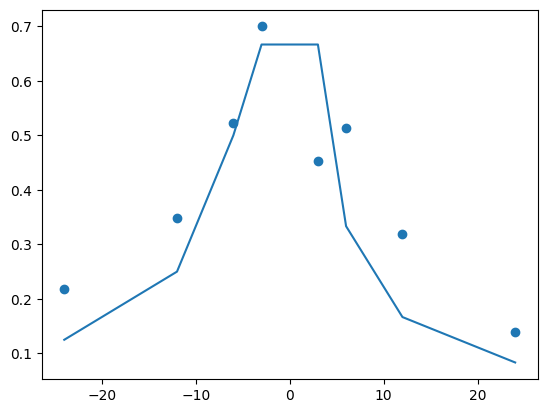

In [9]:
kording_model_fit = kording_job(
    kording_fit_res.x[0],
    kording_fit_res.x[1],
    kording_fit_res.x[2],
    kording_fit_res.x[3],
)

plt.plot(dis, kording_model_fit)
plt.scatter(dis, bias_data)

In [5]:
from skneuromsi.bayesian import Kording2007


def kording_causes_job(a_sigma, v_sigma, p_mu, p_sigma):
    model = Kording2007(position_range=(0, 90), position_res=1)
    sp = ParameterSweep(
        model=model, target="visual_position", repeat=1, n_jobs=1, range=45 + dis
    )
    res = sp.run(
        auditory_position=45,
        visual_sigma=v_sigma,
        auditory_sigma=a_sigma,
        noise=False,
        prior_mu=p_mu,
        prior_sigma=p_sigma,
        strategy="selection",
        causes_kind="prob",
    )
    causes = res.causes.causes_by_parameter(parameter="visual_position")[("", "Causes")]

    return causes


def kording_causes_cost(theta):
    model_data = kording_causes_job(theta[0], theta[1], theta[2], theta[3])
    exp_data = causes_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48), (21, 69), (0.1, 48)]
kording_causes_fit_res = differential_evolution(
    kording_causes_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=-1,
    polish=False,
)
print(kording_causes_fit_res)

differential_evolution step 1: f(x)= 1.16453
differential_evolution step 2: f(x)= 0.778278
differential_evolution step 3: f(x)= 0.292923
differential_evolution step 4: f(x)= 0.292923
differential_evolution step 5: f(x)= 0.292923
differential_evolution step 6: f(x)= 0.292923
differential_evolution step 7: f(x)= 0.292923
differential_evolution step 8: f(x)= 0.292923
differential_evolution step 9: f(x)= 0.292923
differential_evolution step 10: f(x)= 0.292923
differential_evolution step 11: f(x)= 0.292923
differential_evolution step 12: f(x)= 0.165475
differential_evolution step 13: f(x)= 0.165475
differential_evolution step 14: f(x)= 0.133013
differential_evolution step 15: f(x)= 0.114868
differential_evolution step 16: f(x)= 0.0731305
differential_evolution step 17: f(x)= 0.0488369
differential_evolution step 18: f(x)= 0.0415374
differential_evolution step 19: f(x)= 0.0413347
differential_evolution step 20: f(x)= 0.0413347
differential_evolution step 21: f(x)= 0.0413347
differential_evol

Sweeping 'visual_position':   0%|          | 0/8 [00:00<?, ?it/s]

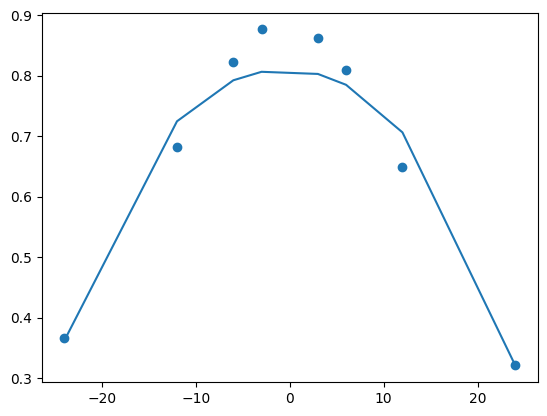

In [6]:
kording_model_causes_fit = kording_causes_job(
    kording_causes_fit_res.x[0],
    kording_causes_fit_res.x[1],
    kording_causes_fit_res.x[2],
    kording_causes_fit_res.x[3],
)

plt.plot(dis, kording_model_causes_fit)
plt.scatter(dis, causes_data)

## Cuppini 2017

In [5]:
from skneuromsi.neural import Cuppini2017


def cuppini2017_job(a_sigma, v_sigma, a_intensity, v_intensity):
    biases = []
    a_pos = 45
    model = Cuppini2017(neurons=90, position_range=(0, 90), position_res=1)
    for v_pos in a_pos + dis:
        res = model.run(
            visual_position=v_pos,
            auditory_position=a_pos,
            visual_sigma=v_sigma,
            auditory_sigma=a_sigma,
            noise=False,
            auditory_intensity=a_intensity,
            visual_intensity=v_intensity,
        )
        max_time = res.to_xarray()["times"].max().values
        estimated_a_pos = (
            res.get_modes("auditory").query("times==@max_time").values.argmax()
        )
        bias = np.absolute(estimated_a_pos - a_pos) / np.absolute(a_pos - v_pos)
        biases.append(bias)
    return np.array(biases)


def cuppini2017_cost(theta):
    model_data = cuppini2017_job(theta[0], theta[1], theta[2], theta[3])
    exp_data = bias_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48), (0.1, 30), (0.1, 30)]
cuppini2017_fit_res = differential_evolution(
    cuppini2017_cost, bounds, disp=True, updating="deferred", workers=-1, polish=False
)
print(cuppini2017_fit_res)

differential_evolution step 1: f(x)= 0.915638
differential_evolution step 2: f(x)= 0.692389
differential_evolution step 3: f(x)= 0.692389
differential_evolution step 4: f(x)= 0.692389
differential_evolution step 5: f(x)= 0.692389
differential_evolution step 6: f(x)= 0.671608
differential_evolution step 7: f(x)= 0.671608
differential_evolution step 8: f(x)= 0.570418
differential_evolution step 9: f(x)= 0.570418
differential_evolution step 10: f(x)= 0.570418
differential_evolution step 11: f(x)= 0.570418
differential_evolution step 12: f(x)= 0.570418
differential_evolution step 13: f(x)= 0.570418
differential_evolution step 14: f(x)= 0.570418
differential_evolution step 15: f(x)= 0.570418
differential_evolution step 16: f(x)= 0.570418
differential_evolution step 17: f(x)= 0.570418
differential_evolution step 18: f(x)= 0.570418
differential_evolution step 19: f(x)= 0.553692
differential_evolution step 20: f(x)= 0.553692
differential_evolution step 21: f(x)= 0.553692
differential_evolution

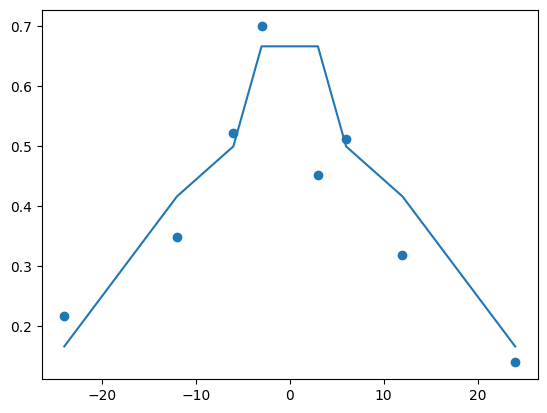

In [6]:
cuppini2017_model_fit = cuppini2017_job(
    cuppini2017_fit_res.x[0],
    cuppini2017_fit_res.x[1],
    cuppini2017_fit_res.x[2],
    cuppini2017_fit_res.x[3],
)

plt.plot(dis, cuppini2017_model_fit)
plt.scatter(dis, bias_data)

In [5]:
from skneuromsi.neural import Cuppini2017


def cuppini2017_causes_job(a_sigma, v_sigma, a_intensity, v_intensity):
    causes = []
    a_pos = 45
    model = Cuppini2017(neurons=90, position_range=(0, 90), position_res=1)
    for v_pos in a_pos + dis:
        res = model.run(
            visual_position=v_pos,
            auditory_position=a_pos,
            visual_sigma=v_sigma,
            auditory_sigma=a_sigma,
            noise=False,
            causes_kind="prob",
            auditory_intensity=a_intensity,
            visual_intensity=v_intensity,
        )
        causes.append(res.causes_)
    return np.array(causes)


def cuppini2017_causes_cost(theta):
    model_data = cuppini2017_causes_job(theta[0], theta[1], theta[2], theta[3])
    exp_data = causes_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48), (0.1, 30), (0.1, 30)]
cuppini2017_causes_fit_res = differential_evolution(
    cuppini2017_causes_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=-1,
    polish=False,
)
print(cuppini2017_causes_fit_res)

differential_evolution step 1: f(x)= 0.192849
differential_evolution step 2: f(x)= 0.192849
differential_evolution step 3: f(x)= 0.192849
differential_evolution step 4: f(x)= 0.14573
differential_evolution step 5: f(x)= 0.14573
differential_evolution step 6: f(x)= 0.125072
differential_evolution step 7: f(x)= 0.125072
differential_evolution step 8: f(x)= 0.125072
differential_evolution step 9: f(x)= 0.125072
differential_evolution step 10: f(x)= 0.125072
differential_evolution step 11: f(x)= 0.125072
differential_evolution step 12: f(x)= 0.0254829
differential_evolution step 13: f(x)= 0.0254829
differential_evolution step 14: f(x)= 0.0254829
differential_evolution step 15: f(x)= 0.0203048
differential_evolution step 16: f(x)= 0.0174151
differential_evolution step 17: f(x)= 0.0174151
differential_evolution step 18: f(x)= 0.0174151
differential_evolution step 19: f(x)= 0.0174151
differential_evolution step 20: f(x)= 0.0174151
differential_evolution step 21: f(x)= 0.0174151
differential_e

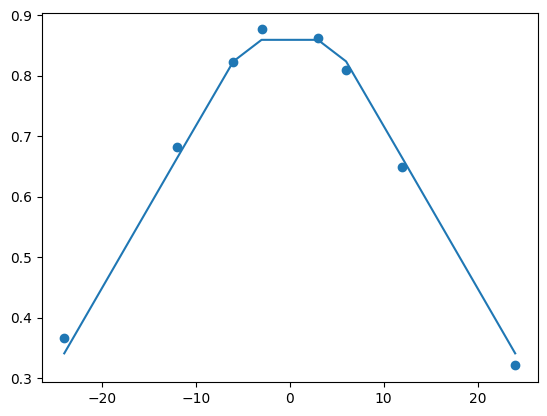

In [6]:
cuppini2017_model_causes_fit = cuppini2017_causes_job(
    cuppini2017_causes_fit_res.x[0],
    cuppini2017_causes_fit_res.x[1],
    cuppini2017_causes_fit_res.x[2],
    cuppini2017_causes_fit_res.x[3],
)

plt.plot(dis, cuppini2017_model_causes_fit)
plt.scatter(dis, causes_data)

In [ ]:
from skneuromsi.neural import Cuppini2017
from skneuromsi.sweep import ProcessingStrategyABC


class CausesProcessingStrategy(ProcessingStrategyABC):
    def map(self, result):
        causes = result.causes_
        del result._nddata
        return causes

    def reduce(self, results, **kwargs):
        return np.array(results, dtype=np.float16)


temporal_causes_data_short = temporal_causes_data[6:-4]


def temporal_cuppini2017_causes_job(a_tau, v_tau, m_tau, ff_weight, cm_weight):
    model = model = Cuppini2017(
        neurons=10,
        position_range=(0, 10),
        position_res=1,
        time_range=(0, 325),
        tau=(a_tau, v_tau, m_tau),
    )

    v_onset = 110
    sp = ParameterSweep(
        model=model,
        target="auditory_onset",
        repeat=1,
        n_jobs=1,
        range=v_onset + temporal_dis[6:-4],
        processing_strategy=CausesProcessingStrategy(),
    )

    res = sp.run(
        feedforward_weight=ff_weight,
        cross_modal_weight=cm_weight,
        noise=False,
        causes_kind="prob",
        causes_dim="time",
        auditory_stim_n=1,
        visual_stim_n=1,
        auditory_duration=6,
        visual_duration=6,
        visual_onset=v_onset,
    )

    return res


def temporal_cuppini2017_causes_cost(theta):
    model_data = temporal_cuppini2017_causes_job(
        theta[0], theta[1], theta[2], theta[3], theta[4]
    )

    exp_data = temporal_causes_data_short

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data))) * 1000

    return cost


bounds = [(0.1, 75), (0.1, 75), (0.1, 75), (0.01, 100), (0.01, 25)]
cuppini2017_temporal_causes_fit_res = differential_evolution(
    temporal_cuppini2017_causes_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=28,
    polish=False,
    seed=111,
)
print(cuppini2017_temporal_causes_fit_res)
# np.save("Cuppini_2017_temporal_fit_res_pars.npy", cuppini2017_temporal_causes_fit_res)

KeyboardInterrupt: 

In [ ]:
print(cuppini2017_temporal_causes_fit_res)

 message: Optimization terminated successfully.
 success: True
     fun: 1.4470536968994083
       x: [ 3.440e+01  2.887e+01  7.492e+01]
     nit: 69
    nfev: 3150


Sweeping 'auditory_onset':   0%|          | 0/13 [00:00<?, ?it/s]

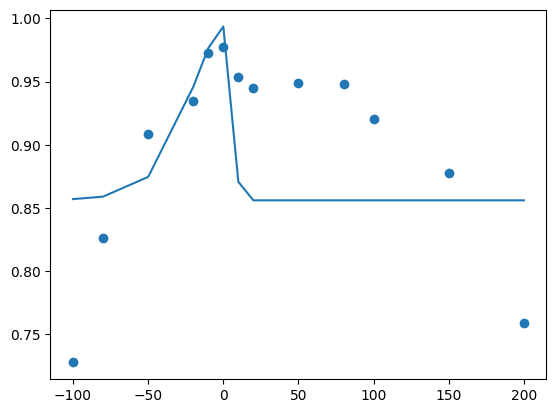

In [8]:
cuppini2017_temporal_causes_fit_res = np.load("Cuppini_2017_temporal_fit_res_pars.npy")
temporal_cuppini2017_model_causes_fit = temporal_cuppini2017_causes_job(
    cuppini2017_temporal_causes_fit_res[0],
    cuppini2017_temporal_causes_fit_res[1],
    cuppini2017_temporal_causes_fit_res[2],
    cuppini2017_temporal_causes_fit_res[3],
    cuppini2017_temporal_causes_fit_res[4],
)

plt.plot(temporal_dis[6:-4], temporal_cuppini2017_model_causes_fit)
plt.scatter(temporal_dis[6:-4], temporal_causes_data[6:-4])

## Paredes

In [9]:
from skneuromsi.neural import Paredes2022


def paredes2022_job(a_sigma, v_sigma, a_intensity, v_intensity):
    biases = []
    a_pos = 45
    model = Paredes2022(
        neurons=90, position_range=(0, 90), position_res=1, time_range=(0, 100)
    )
    for v_pos in a_pos + dis:
        res = model.run(
            visual_position=v_pos,
            auditory_position=a_pos,
            visual_sigma=v_sigma,
            auditory_sigma=a_sigma,
            noise=False,
            auditory_intensity=a_intensity,
            visual_intensity=v_intensity,
            auditory_soa=None,
            auditory_stim_n=1,
            visual_stim_n=1,
            auditory_duration=100,
            visual_duration=100,
            auditory_onset=0,
            visual_onset=0,
        )
        max_time = res.to_xarray()["times"].max().values
        estimated_a_pos = (
            res.get_modes("auditory").query("times==@max_time").values.argmax()
        )
        bias = np.absolute(estimated_a_pos - a_pos) / np.absolute(a_pos - v_pos)
        biases.append(bias)
    return np.array(biases)


def paredes2022_cost(theta):
    model_data = paredes2022_job(theta[0], theta[1], theta[2], theta[3])
    exp_data = bias_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48), (0.1, 30), (0.1, 30)]
paredes2022_fit_res = differential_evolution(
    paredes2022_cost, bounds, disp=True, updating="deferred", workers=28, polish=False
)
print(paredes2022_fit_res)

differential_evolution step 1: f(x)= 50.1213
differential_evolution step 2: f(x)= 50.1213
differential_evolution step 3: f(x)= 47.2535
differential_evolution step 4: f(x)= 14.4285
differential_evolution step 5: f(x)= 12.3938
differential_evolution step 6: f(x)= 3.53395
differential_evolution step 7: f(x)= 3.53395
differential_evolution step 8: f(x)= 3.53395
differential_evolution step 9: f(x)= 1.52297
differential_evolution step 10: f(x)= 1.52297
differential_evolution step 11: f(x)= 0.866251
differential_evolution step 12: f(x)= 0.84268
differential_evolution step 13: f(x)= 0.84268
differential_evolution step 14: f(x)= 0.84268
differential_evolution step 15: f(x)= 0.84268
differential_evolution step 16: f(x)= 0.84268
differential_evolution step 17: f(x)= 0.84268
differential_evolution step 18: f(x)= 0.84268
differential_evolution step 19: f(x)= 0.84268
differential_evolution step 20: f(x)= 0.84268
differential_evolution step 21: f(x)= 0.84268
differential_evolution step 22: f(x)= 0.84

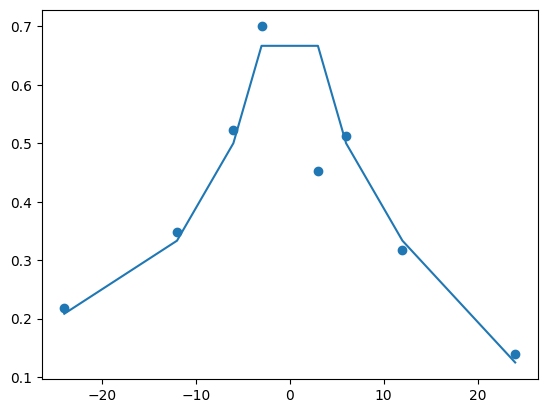

In [11]:
paredes2022_model_fit = paredes2022_job(
    paredes2022_fit_res.x[0],
    paredes2022_fit_res.x[1],
    paredes2022_fit_res.x[2],
    paredes2022_fit_res.x[3],
)

plt.plot(dis, paredes2022_model_fit)
plt.scatter(dis, bias_data)

In [9]:
from skneuromsi.neural import Paredes2022


def paredes2022_causes_job(a_sigma, v_sigma, a_intensity, v_intensity):
    causes = []
    a_pos = 45
    model = Paredes2022(
        neurons=90, position_range=(0, 90), position_res=1, time_range=(0, 150)
    )
    for v_pos in a_pos + dis:
        res = model.run(
            visual_position=v_pos,
            auditory_position=a_pos,
            auditory_sigma=a_sigma,
            visual_sigma=v_sigma,
            noise=False,
            auditory_intensity=a_intensity,
            visual_intensity=v_intensity,
            causes_kind="prob",
            auditory_soa=None,
            visual_soa=None,
            auditory_stim_n=1,
            visual_stim_n=1,
            auditory_duration=150,
            visual_duration=150,
            auditory_onset=0,
            visual_onset=0,
            causes_peak_threshold=0.15,
        )
        causes.append(res.causes_)

    return np.array(causes)


def paredes2022_causes_cost(theta):
    model_data = paredes2022_causes_job(theta[0], theta[1], theta[2], theta[3])
    exp_data = causes_data

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    if theta[0] < theta[1]:
        cost = 100000000000

    return cost


bounds = [(0.1, 48), (0.1, 48), (0.1, 30), (0.1, 30)]
paredes2022_causes_fit_res = differential_evolution(
    paredes2022_causes_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=30,
    polish=False,
)
print(paredes2022_causes_fit_res)

differential_evolution step 1: f(x)= 1.38471
differential_evolution step 2: f(x)= 1.30339
differential_evolution step 3: f(x)= 1.30339
differential_evolution step 4: f(x)= 1.03119
differential_evolution step 5: f(x)= 1.03119
differential_evolution step 6: f(x)= 1.03045
differential_evolution step 7: f(x)= 1.03045
differential_evolution step 8: f(x)= 1.03045
differential_evolution step 9: f(x)= 1.03045
differential_evolution step 10: f(x)= 1.03045
differential_evolution step 11: f(x)= 1.03045
differential_evolution step 12: f(x)= 1.03045
differential_evolution step 13: f(x)= 1.03045
differential_evolution step 14: f(x)= 1.03045
differential_evolution step 15: f(x)= 1.03045
differential_evolution step 16: f(x)= 1.03045
differential_evolution step 17: f(x)= 1.03045
differential_evolution step 18: f(x)= 1.03045
differential_evolution step 19: f(x)= 0.410174
differential_evolution step 20: f(x)= 0.410174
differential_evolution step 21: f(x)= 0.410174
differential_evolution step 22: f(x)= 0.

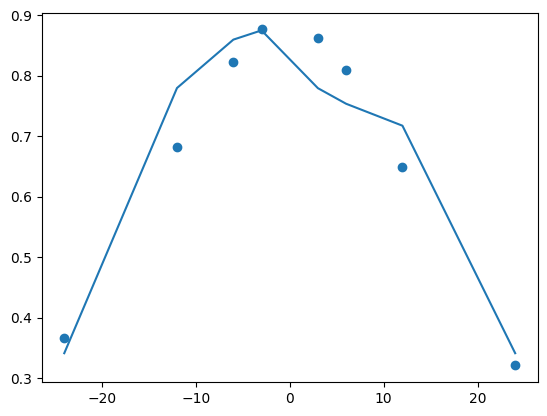

In [10]:
paredes2022_model_causes_fit = paredes2022_causes_job(
    paredes2022_causes_fit_res.x[0],
    paredes2022_causes_fit_res.x[1],
    paredes2022_causes_fit_res.x[2],
    paredes2022_causes_fit_res.x[3],
)

plt.plot(dis, paredes2022_model_causes_fit)
plt.scatter(dis, causes_data)

In [5]:
from skneuromsi.neural import Paredes2022
from skneuromsi.sweep import ProcessingStrategyABC


class CausesProcessingStrategy(ProcessingStrategyABC):
    def map(self, result):
        causes = result.causes_
        del result._nddata
        return causes

    def reduce(self, results, **kwargs):
        return np.array(results, dtype=np.float32)


temporal_causes_data_short = temporal_causes_data[6:-4]


def temporal_paredes2022_causes_job(a_tau, v_tau, m_tau, ff_weight, cm_weight):
    model = model = Paredes2022(
        neurons=10,
        position_range=(0, 10),
        position_res=1,
        time_range=(0, 350),
        tau=(a_tau, v_tau, m_tau),
    )

    v_onset = 110
    sp = ParameterSweep(
        model=model,
        target="auditory_onset",
        repeat=1,
        n_jobs=1,
        range=v_onset + temporal_dis[6:-4],
        processing_strategy=CausesProcessingStrategy(),
    )

    res = sp.run(
        auditory_intensity=3,
        visual_intensity=2.9,
        feedforward_weight=ff_weight,
        cross_modal_weight=cm_weight,
        noise=False,
        causes_kind="prob",
        causes_dim="time",
        auditory_soa=None,
        visual_soa=None,
        auditory_stim_n=1,
        visual_stim_n=1,
        auditory_duration=6,
        visual_duration=6,
        visual_onset=v_onset,
        causes_peak_threshold=0.15,
        feed_latency=24,
    )

    return res


def temporal_paredes2022_causes_cost(theta):
    model_data = temporal_paredes2022_causes_job(
        theta[0], theta[1], theta[2], theta[3], theta[4]
    )
    exp_data = temporal_causes_data_short

    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data))) * 1000

    return cost


bounds = [(0.1, 75), (0.1, 75), (0.1, 75), (0.001, 100), (0.001, 0.12)]
paredes2022_temporal_causes_fit_res = differential_evolution(
    temporal_paredes2022_causes_cost,
    bounds,
    disp=True,
    updating="deferred",
    workers=28,
    polish=False,
)

print(paredes2022_temporal_causes_fit_res)
np.save("Paredes_2022_temporal_fit_res_pars.npy", paredes2022_temporal_causes_fit_res.x)

differential_evolution step 1: f(x)= 333.517
differential_evolution step 2: f(x)= 333.517
differential_evolution step 3: f(x)= 333.517
differential_evolution step 4: f(x)= 333.517
differential_evolution step 5: f(x)= 333.517
differential_evolution step 6: f(x)= 333.517
differential_evolution step 7: f(x)= 333.517
differential_evolution step 8: f(x)= 333.517
differential_evolution step 9: f(x)= 333.517
differential_evolution step 10: f(x)= 333.517
differential_evolution step 11: f(x)= 333.517
differential_evolution step 12: f(x)= 333.517
differential_evolution step 13: f(x)= 333.517
differential_evolution step 14: f(x)= 333.517
differential_evolution step 15: f(x)= 333.517
differential_evolution step 16: f(x)= 333.517
differential_evolution step 17: f(x)= 333.517
differential_evolution step 18: f(x)= 333.517
differential_evolution step 19: f(x)= 333.517
differential_evolution step 20: f(x)= 333.517
differential_evolution step 21: f(x)= 316.05
differential_evolution step 22: f(x)= 316.05

In [6]:
print(paredes2022_temporal_causes_fit_res)

 message: Optimization terminated successfully.
 success: True
     fun: 77.08211961261908
       x: [ 2.889e+00  6.359e+00  1.841e+01  3.876e+00  1.292e-03]
     nit: 105
    nfev: 7950


Sweeping 'auditory_onset':   0%|          | 0/13 [00:00<?, ?it/s]

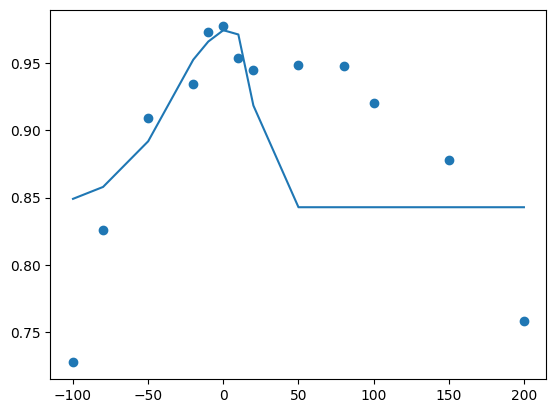

In [7]:
paredes2022_temporal_causes_fit_res = np.load("Paredes_2022_temporal_fit_res_pars.npy")
temporal_paredes2022_model_causes_fit = temporal_paredes2022_causes_job(
    paredes2022_temporal_causes_fit_res[0],
    paredes2022_temporal_causes_fit_res[1],
    paredes2022_temporal_causes_fit_res[2],
    paredes2022_temporal_causes_fit_res[3],
    paredes2022_temporal_causes_fit_res[4],
)

plt.plot(temporal_dis[6:-4], temporal_paredes2022_model_causes_fit)
plt.scatter(temporal_dis[6:-4], temporal_causes_data_short)

In [95]:
def explore_temporal_paredes2022_causes_job(a_tau, v_tau, m_tau, ff_weight, cm_weight):
    model = model = Paredes2022(
        neurons=10,
        position_range=(0, 10),
        position_res=1,
        time_range=(0, 350),
        tau=(a_tau, v_tau, m_tau),
    )

    v_onset = 110
    sp = ParameterSweep(
        model=model,
        target="auditory_onset",
        repeat=1,
        n_jobs=1,
        range=v_onset + temporal_dis[6:-4],
    )

    res = sp.run(
        auditory_intensity=3,
        visual_intensity=2.9,
        feedforward_weight=ff_weight,
        cross_modal_weight=cm_weight,
        noise=False,
        causes_kind="prob",
        causes_dim="time",
        auditory_soa=None,
        visual_soa=None,
        auditory_stim_n=1,
        visual_stim_n=1,
        auditory_duration=6,
        visual_duration=6,
        visual_onset=v_onset,
        causes_peak_threshold=0.15,
        feed_latency=24,
    )

    return res


exp_res = explore_temporal_paredes2022_causes_job(
    25,  # paredes2022_temporal_causes_fit_res[0],
    25,  # paredes2022_temporal_causes_fit_res[1],
    5,  # paredes2022_temporal_causes_fit_res[2],
    0,  # paredes2022_temporal_causes_fit_res[3],
    0.12,  # paredes2022_temporal_causes_fit_res[4],
)

exp_res

Sweeping 'auditory_onset':   0%|          | 0/13 [00:00<?, ?it/s]

<NDResultCollection 'ParameterSweep' len=13>

array([<Axes: title={'center': 'x0'}, xlabel='times', ylabel='values'>],
      dtype=object)

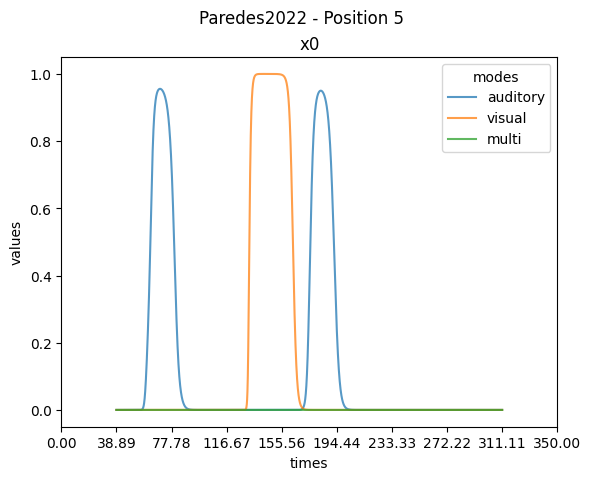

In [96]:
exp_res[0].plot.linet()

In [ ]:
# Try without feedback. Then explore if it is required.
# Explore Cuppini 2017 limits and set it up to optimise fit.

array([19.26561006, 48.52081771,  7.81626775, 54.6791693 , 24.46639687])